In [5]:
# !pip install torch torchvision transformers

In [6]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model_name_or_path = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name_or_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ashgatsy/miniconda3/envs/env1/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [16]:
import os
import torch
from torchvision import transforms
from PIL import Image
import random

In [14]:
# Path to your coco_train2017 folder
data_folder = "/home/ashgatsy/coco_train2017"

In [12]:
# Define the transformation (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [20]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)    
    except BadZipFile as e:
        print("Error:", e)
extract_train_path = "/home/ashgatsy/coco_train2017"
extract_val_path = "/home/ashgatsy/coco_val2017"
extract_ann_path="/home/ashgatsy/coco_ann2017"
extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [21]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [22]:
coco_annotations_file="/home/ashgatsy/coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="/home/ashgatsy/coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [25]:
# !pip install matplotlib

Image 1 embedding shape: torch.Size([1, 3, 224, 224])
tensor([[[-0.9686, -0.9686, -0.9529,  ..., -0.2235, -0.5765, -0.5765],
         [-0.9765, -0.9843, -0.9686,  ..., -0.1843, -0.5686, -0.5843],
         [-0.9765, -0.9686, -0.9608,  ..., -0.1843, -0.5765, -0.5529],
         ...,
         [-0.7412, -0.7412, -0.7647,  ..., -0.5765, -0.5843, -0.5843],
         [-0.7412, -0.7490, -0.7490,  ..., -0.5765, -0.5843, -0.5686],
         [-0.7333, -0.7333, -0.7098,  ..., -0.5843, -0.5843, -0.5686]],

        [[-0.9529, -0.9686, -0.9529,  ..., -0.1216, -0.3725, -0.3882],
         [-0.9608, -0.9686, -0.9608,  ..., -0.1765, -0.3725, -0.3882],
         [-0.9608, -0.9529, -0.9451,  ..., -0.2471, -0.3804, -0.3725],
         ...,
         [-0.4902, -0.4902, -0.4902,  ..., -0.4431, -0.4431, -0.4431],
         [-0.4824, -0.4902, -0.4824,  ..., -0.4353, -0.4353, -0.4431],
         [-0.4824, -0.5059, -0.4667,  ..., -0.4275, -0.4353, -0.4431]],

        [[-0.9765, -0.9843, -0.9765,  ..., -0.0824, -0.3255, -

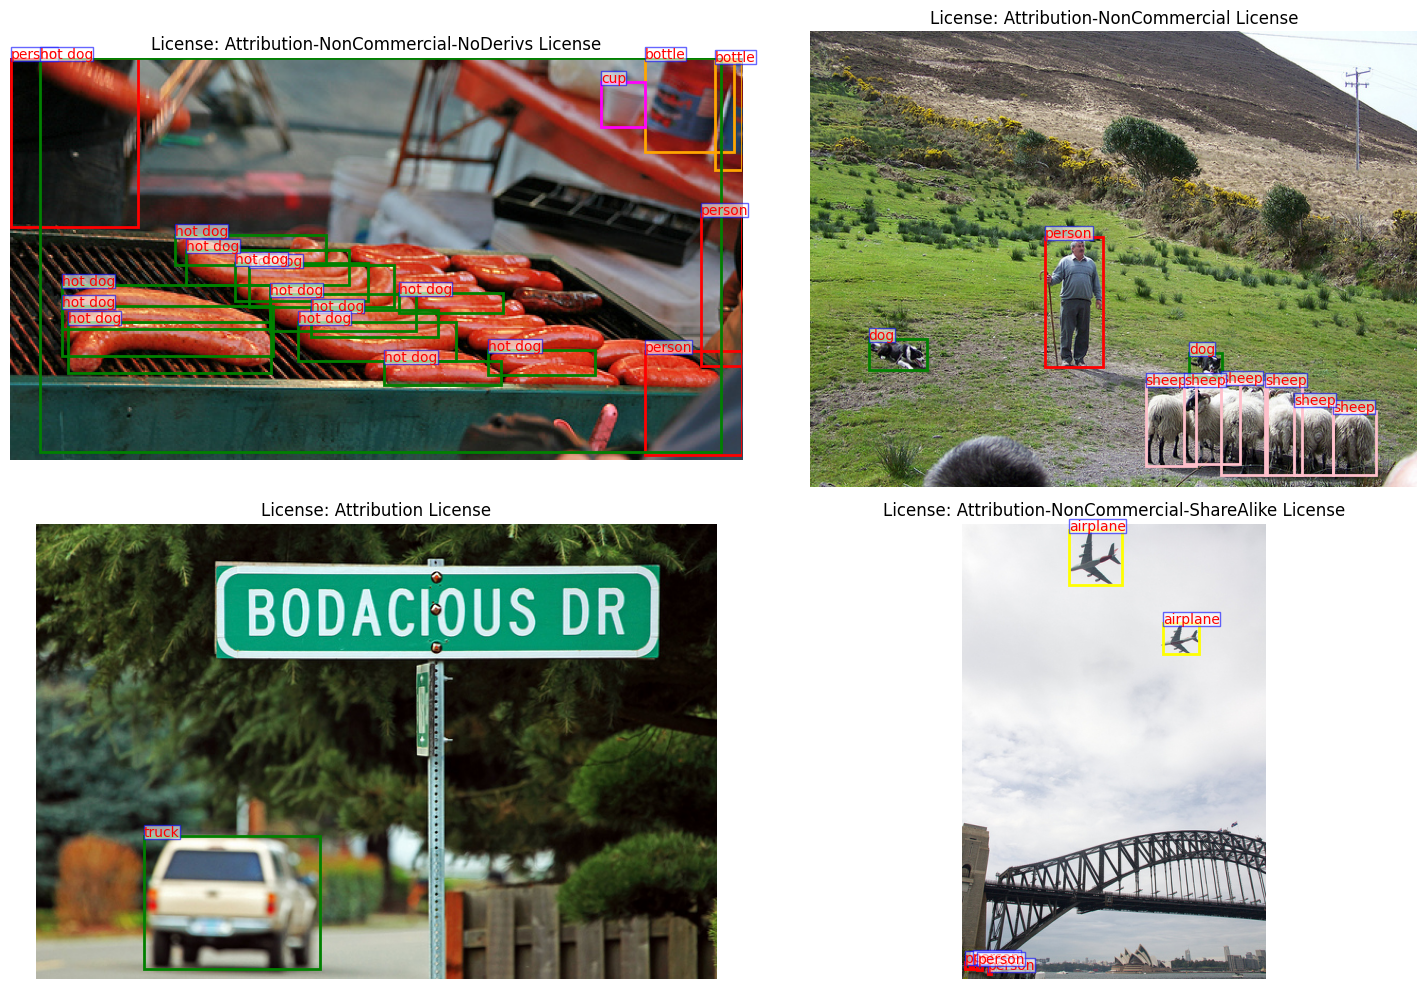

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    img_tensor = transform(image)
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        features = inputs.pixel_values

    # Print the embedding vector
    print(f"Image {i + 1} embedding shape: {features.shape}")
    print(features[0])  # Print the first embedding vector
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()